In [187]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn
!pip install xgboost
!pip install shap

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, confusion_matrix
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


### Import and Visualize dataset:
- Number rows and columns
- Look at a dataset sample
- Calculate the balance between 'good' and 'bad'

In [189]:
df = pd.read_csv('credit-g.csv')
print('shape: ',df.shape)
print(df.head())
print('columns: ',df.columns)

shape:  (1000, 21)
  checking_status  duration                  credit_history  \
0              <0         6  critical/other existing credit   
1        0<=X<200        48                   existing paid   
2     no checking        12  critical/other existing credit   
3              <0        42                   existing paid   
4              <0        24              delayed previously   

               purpose  credit_amount    savings_status employment  \
0             radio/tv           1169  no known savings        >=7   
1             radio/tv           5951              <100     1<=X<4   
2            education           2096              <100     4<=X<7   
3  furniture/equipment           7882              <100     4<=X<7   
4              new car           4870              <100     1<=X<4   

   installment_commitment     personal_status other_parties  ...  \
0                       4         male single          none  ...   
1                       2  female div/dep/mar

In [190]:
df.groupby('class').agg({'class': len})

,class
class,
bad,300
good,700


### Notes:
- 7 features are numerical, the other ones are categorical
- bad customers make up 30% of the dataset or a 43% ratio

### Data Preparation
- Look for any missing values
- Examine data types for all columns

In [191]:
# Look for any NaN values
print(df.isnull().any())
# Look at Types
print(df.dtypes)

checking_status           False
duration                  False
credit_history            False
purpose                   False
credit_amount             False
savings_status            False
employment                False
installment_commitment    False
personal_status           False
other_parties             False
residence_since           False
property_magnitude        False
age                       False
 other_payment_plans      False
housing                   False
existing_credits          False
job                       False
num_dependents            False
own_telephone             False
 foreign_worker           False
class                     False
dtype: bool
checking_status           object
duration                   int64
credit_history            object
purpose                   object
credit_amount              int64
savings_status            object
employment                object
installment_commitment     int64
personal_status           object
other_parties      

### Data Exploration
- Split the dataset between numerical and categorical features to look at those separately
- Create numerical classes for easier exploration
- Visualize correlation using Pearson Correlations
- Visualize distributions of classes by feature to gauge potential correlations with good/bad ratings

In [192]:
numerical_feats = ['duration','credit_amount', 'installment_commitment', \
       'residence_since', 'age', 'existing_credits', 'num_dependents']
cat_feats = [x for x in df.columns if x not in numerical_feats][:-1]

In [193]:
# Create numerical classes for easier exploration
print(df['class'].unique())
df['class_num'] = df['class'].apply(lambda x: 1 if x == 'good' else 0)

['good' 'bad']


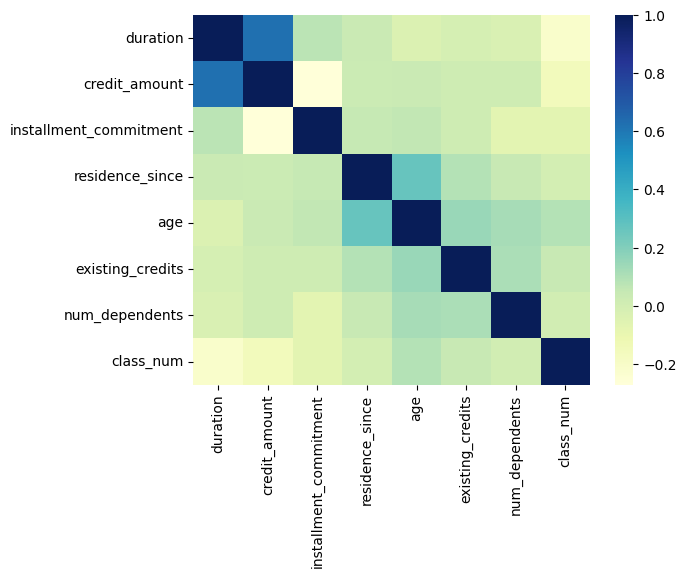

In [194]:
# Pearson correlation matrix
df_num = df[numerical_feats+['class_num']]
sns.heatmap(df_num.corr(), cmap="YlGnBu")
plt.show()

-> No numerical features has high correlation with the class

#### Numerical Features:
- Let's visualize numerical features first
- Using 2 charts: the mean value for each class and the distribution of values between classes
- This will give us a visual idea of the separation between classes for each feature

        duration
class           
bad    24.860000
good   19.207143


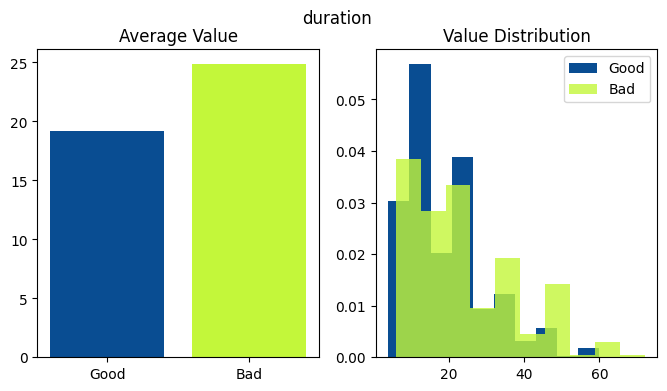

       credit_amount
class               
bad      3938.126667
good     2985.457143


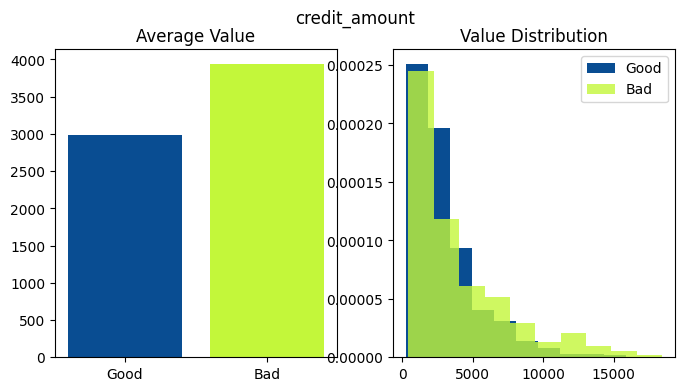

       installment_commitment
class                        
bad                  3.096667
good                 2.920000


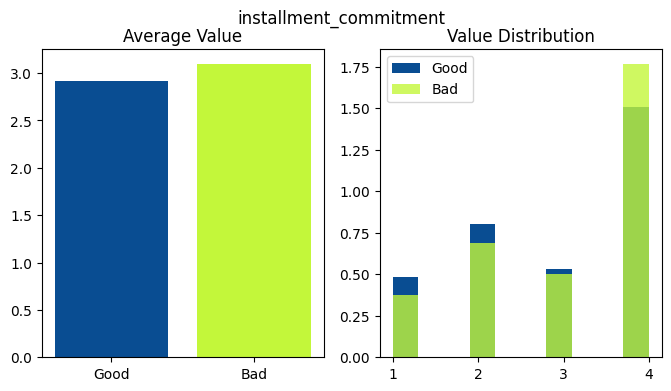

       residence_since
class                 
bad           2.850000
good          2.842857


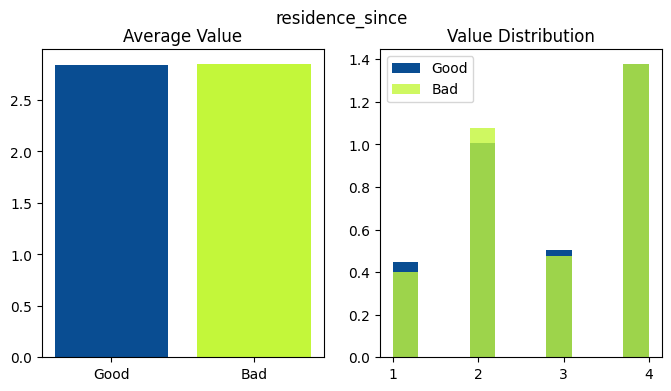

             age
class           
bad    33.963333
good   36.224286


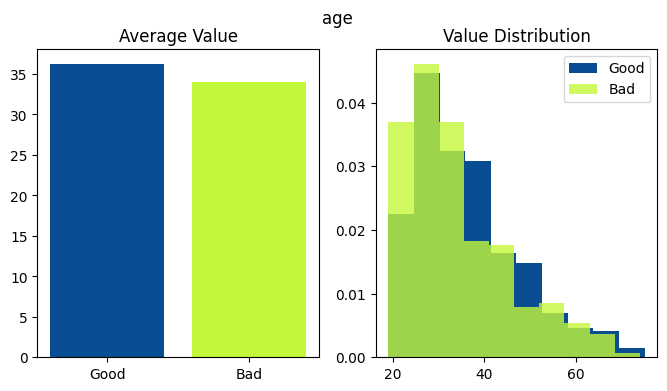

       existing_credits
class                  
bad            1.366667
good           1.424286


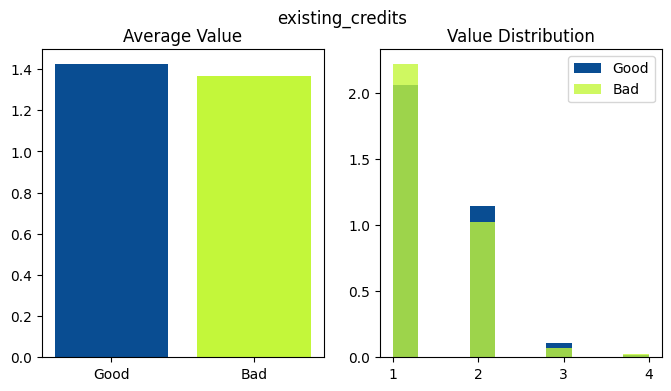

       num_dependents
class                
bad          1.153333
good         1.155714


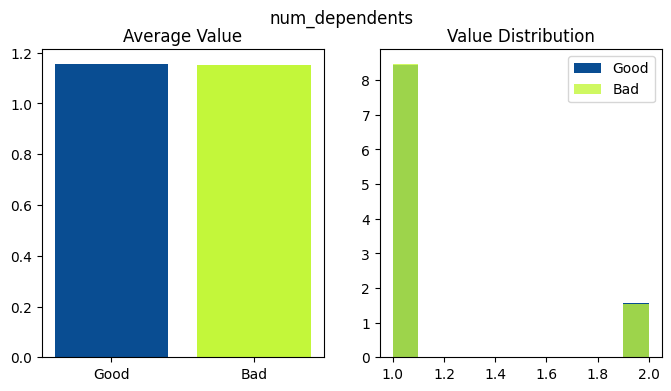

In [195]:
def numeric_desc(col):
    tmp = df[[col, 'class']]
    
    class_averages = tmp.groupby(['class']).agg({col: np.mean})
    good, bad = class_averages.loc['good'][0], class_averages.loc['bad'][0]
    print(class_averages)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    fig.suptitle(col)
    ax1.bar(['Good', 'Bad'],[good, bad], color = ['#094D92','#C3F73A'], alpha = 1)
    ax1.set_title('Average Value')
    ax2.hist(df_num[df_num['class_num'] == 1][col], density = True, color = '#094D92')
    ax2.hist(df_num[df_num['class_num'] == 0][col], density = True, color = '#C3F73A', alpha = 0.8)
    ax2.set_title('Value Distribution')
    plt.legend(['Good', 'Bad'])
    plt.show()

for feat in numerical_feats:
    numeric_desc(feat)

#### Hypotheses from visual exploration:
- The following features in particular show separation between classes: Duration, Credit Amount

### Quantify the potential impact of features - Numerical Features:
- Let's look at features with the biggest difference between avg values for 1 and 0 class
- credit_amount and duration seem to be the most differentiated between good and bad

In [196]:
#Feature differentiation:
def num_feature_differentiation(feat):
    subset = df[[feat, 'class']]
    avg_class_value = subset.groupby('class').agg({feat: np.mean}).sort_values(feat, ascending=False)
    max_val, min_val = max(avg_class_value[feat]), min(avg_class_value[feat])
    
    diff = (max_val-min_val) / min_val
    return feat, diff

num_feature_differentiation_df = pd.DataFrame(columns = ['Feature', '% Value Difference btw good and bad'])

for i, feature in enumerate(numerical_feats):
    num_feature_differentiation_df.loc[i] = num_feature_differentiation(feature)

num_feature_differentiation_df.sort_values('% Value Difference btw good and bad', ascending=False, inplace=True)    
num_feature_differentiation_df

,Feature,% Value Difference btw good and bad
1,credit_amount,0.319103
0,duration,0.294310
4,age,0.066570
2,installment_commitment,0.060502
5,existing_credits,0.042160
3,residence_since,0.002513
6,num_dependents,0.002064


#### Categorical Features:
- We'll look at the mean class value for each category
- We'll plot the average value to see how different classes compare with it
- It will allow us to visually assess if some categories have a lot of separation with others

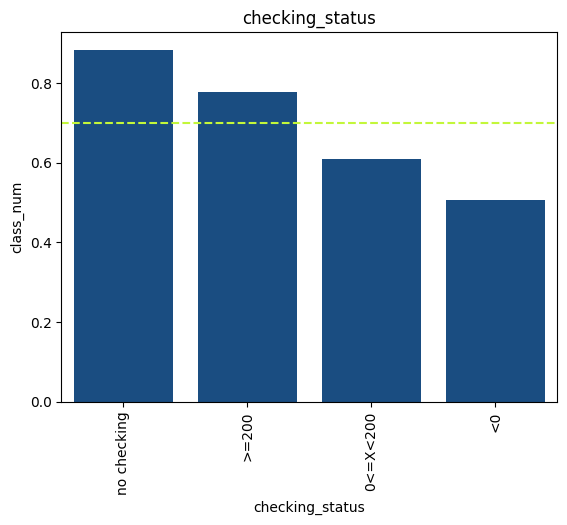

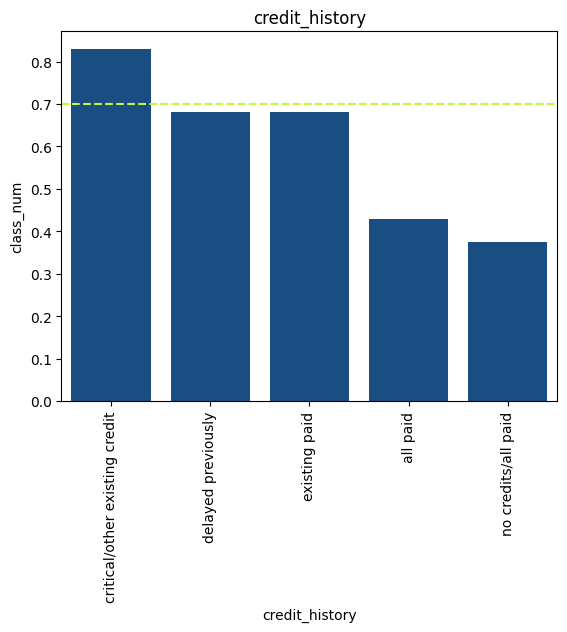

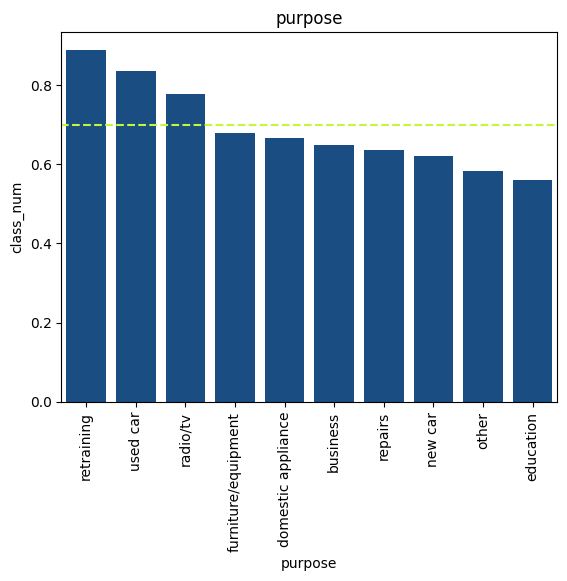

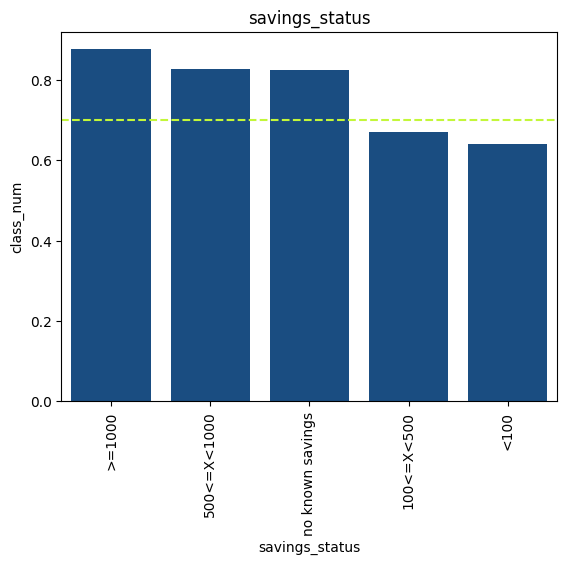

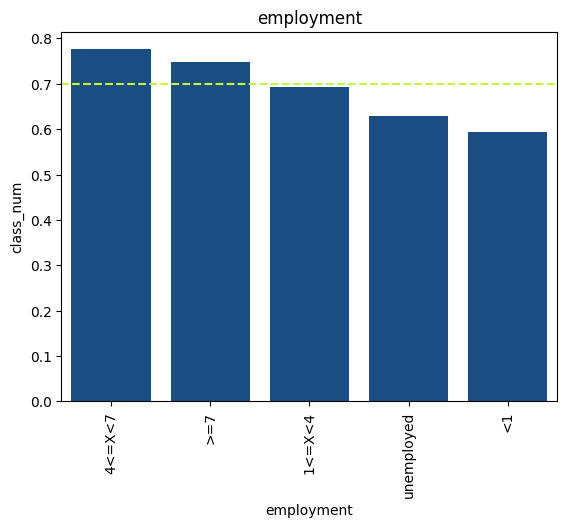

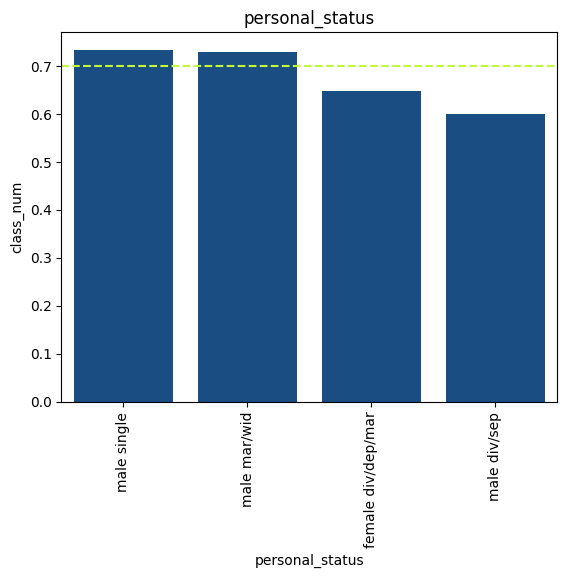

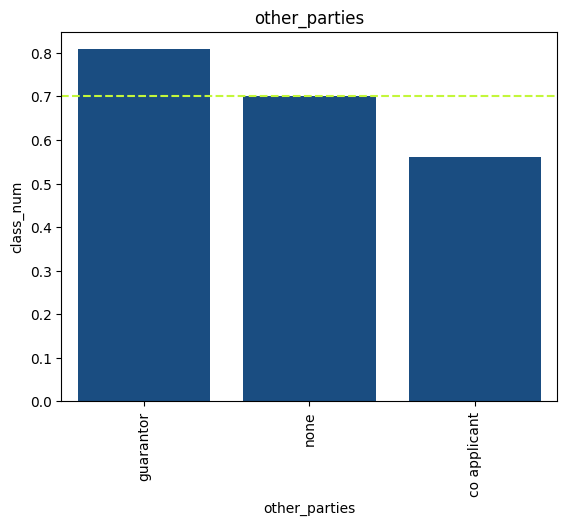

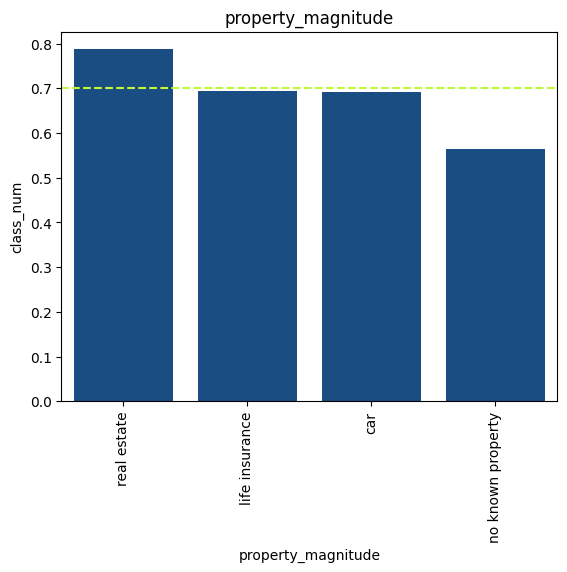

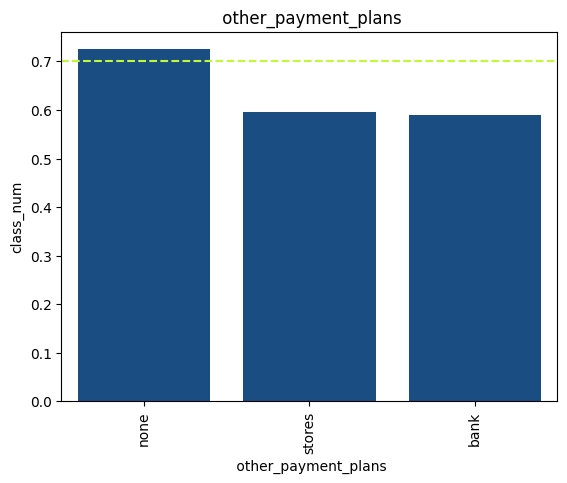

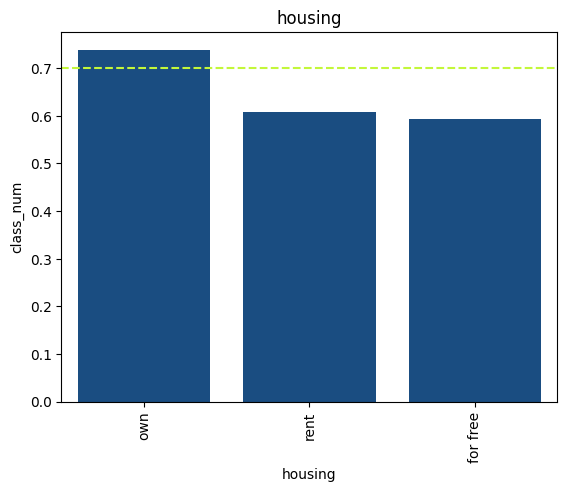

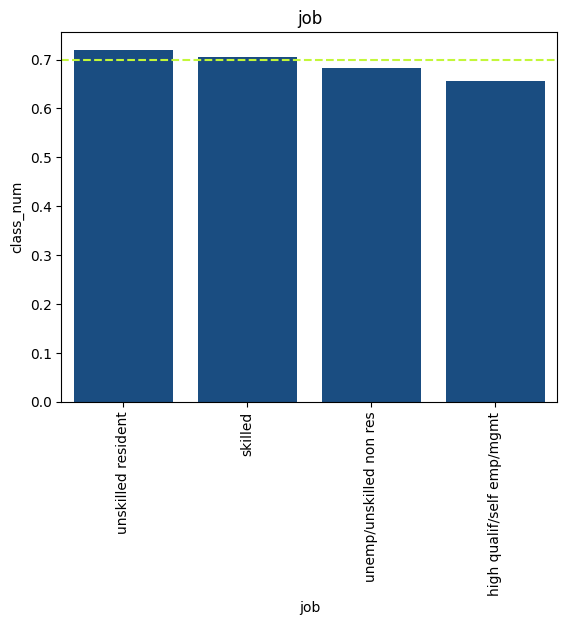

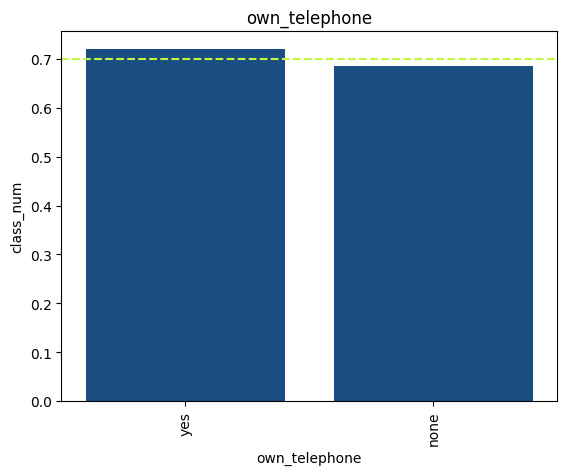

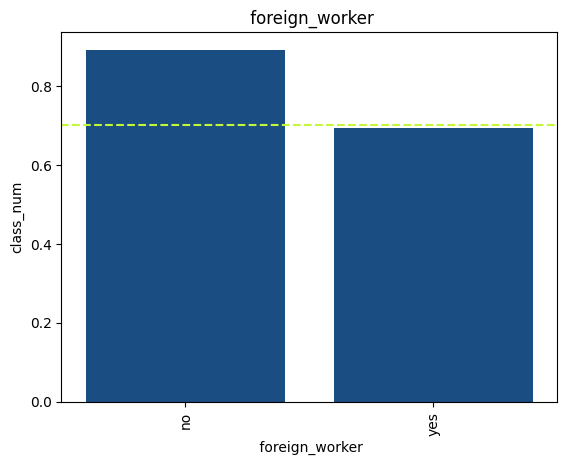

In [197]:
score_mean = df['class_num'].mean()

def cat_cols(col):
    tmp = df[[col, 'class_num']]
    scores = tmp.groupby([col]).agg({'class_num': np.mean})
    scores.sort_values('class_num',inplace=True, ascending=False)
    sns.barplot(data=scores, x=scores.index, y='class_num', color='#094D92')
    plt.axhline(score_mean, color = '#C3F73A', linestyle='--')
    plt.xticks(rotation=90)
    plt.title(f'{col}')
    plt.show()
    
for feat in cat_feats:
    cat_cols(feat)

#### Hypotheses from visual exploration:
- The following features in particular show separation between classes: Credit History,  Credit Status, Purpose, Savings Status

### Quantify the potential impact of features - Categorical Features:
- Let's look at the difference in average class score between the highest and lowest category
- credit_history, checking_status, purpose seem to have the highest differentiation

In [198]:
# Features with biggest separation between high and low:

def feature_differentiation(feat):
    subset = df[[feat, 'class_num']]
    avg_category_value = subset.groupby([feat]).agg({'class_num': np.mean}).sort_values('class_num', ascending=False)
    max_val, max_cat = avg_category_value['class_num'][0], avg_category_value.index[0]
    min_val, min_cat = avg_category_value['class_num'][-1], avg_category_value.index[-1]
    
    diff = (max_val-min_val) / min_val
    return feat, max_cat, min_val, diff

feature_differentiation_df = pd.DataFrame(columns = ['Feature', 'Max Category', 'Min Category', '% Difference'])

for i, feature in enumerate(cat_feats):
    feature_differentiation_df.loc[i] = feature_differentiation(feature)

feature_differentiation_df.sort_values('% Difference', ascending=False, inplace=True)    
feature_differentiation_df


,Feature,Max Category,Min Category,% Difference
1,credit_history,critical/other existing credit,0.375000,1.211604
0,checking_status,no checking,0.507299,0.741080
2,purpose,retraining,0.560000,0.587302
6,other_parties,guarantor,0.560976,0.439799
7,property_magnitude,real estate,0.564935,0.393495
3,savings_status,>=1000,0.640133,0.366904
4,employment,4<=X<7,0.593023,0.308316
12,foreign_worker,no,0.692627,0.287694
9,housing,own,0.592593,0.247283
8,other_payment_plans,none,0.589928,0.228651


### Modeling the credit risk

Create the dataset for the model:
- One-hot encode Categorical Variables
- Remove characters not supported by the model
- Create a training and a testing set

In [199]:
#One-hot encoding:
X = pd.get_dummies(df[df.columns[:-2]])

#Replace characters that cause problem:
for i,a in enumerate(X.columns):
    b = a.replace('>',')')
    b = b.replace('<','(')
    X.rename({a: b}, inplace=True, axis = 1)

y = df['class_num']

#Create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=43)


-> One-hot encoding creates 60 total features, which is high for a dataset of 1000 observations, so we'll look at feature importance to try and select only the more important features

### Modeling the credit risk:
- Build model with standard parameters
- Using 43% imbalance ratio as starting point
- We'll use the classification report and the confusion matrix to gauge the overall performance of the model
- The model does well identifying good ratings: in practice, you'd want to optimize for the 0 class, to find potential bad creditors


In [200]:
clf = xgb.XGBClassifier(
    learning_rate = 0.1, 
    n_estimators = 100,
    scale_pos_weight=0.43,
    max_depth=3,
    use_label_encoder=False 
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.54      0.51        65
           1       0.76      0.72      0.74       135

    accuracy                           0.66       200
   macro avg       0.62      0.63      0.62       200
weighted avg       0.67      0.66      0.66       200



-> By Tuning the model, we want to optimize the 0 recall and the 0 f1-score
### Feature Importance - using xgboost's built-in methodology:

Feature Importances from the model


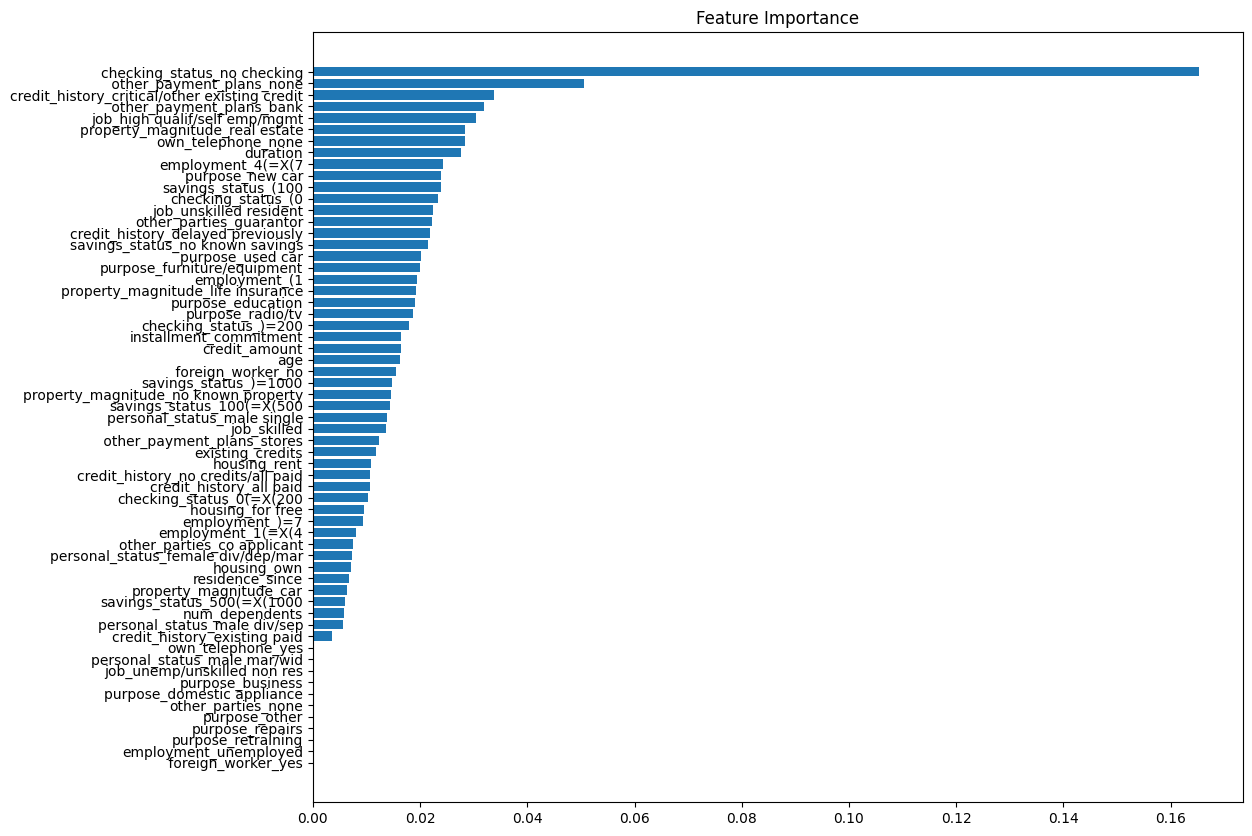

In [201]:
print('Feature Importances from the model')
feature_importances_df = pd.DataFrame()
feature_importances_df['features'], feature_importances_df['importance'] = X_train.columns, clf.feature_importances_
feature_importances_df.sort_values('importance', ascending=True, inplace=True)
fig,ax = plt.subplots(figsize=(12,10))
plt.barh(feature_importances_df['features'][0:],feature_importances_df['importance'][0:])
plt.title('Feature Importance')
plt.show()

-> It looks like importance is dropping significantly towards the end: we should be able to remove some features

### Feature Importance - using Shapley Values:
- The 3 most important features according to Shapley Valuesare Checking_status, duration, credit_history/credit_amount

Feature Importances using Shapley Values


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


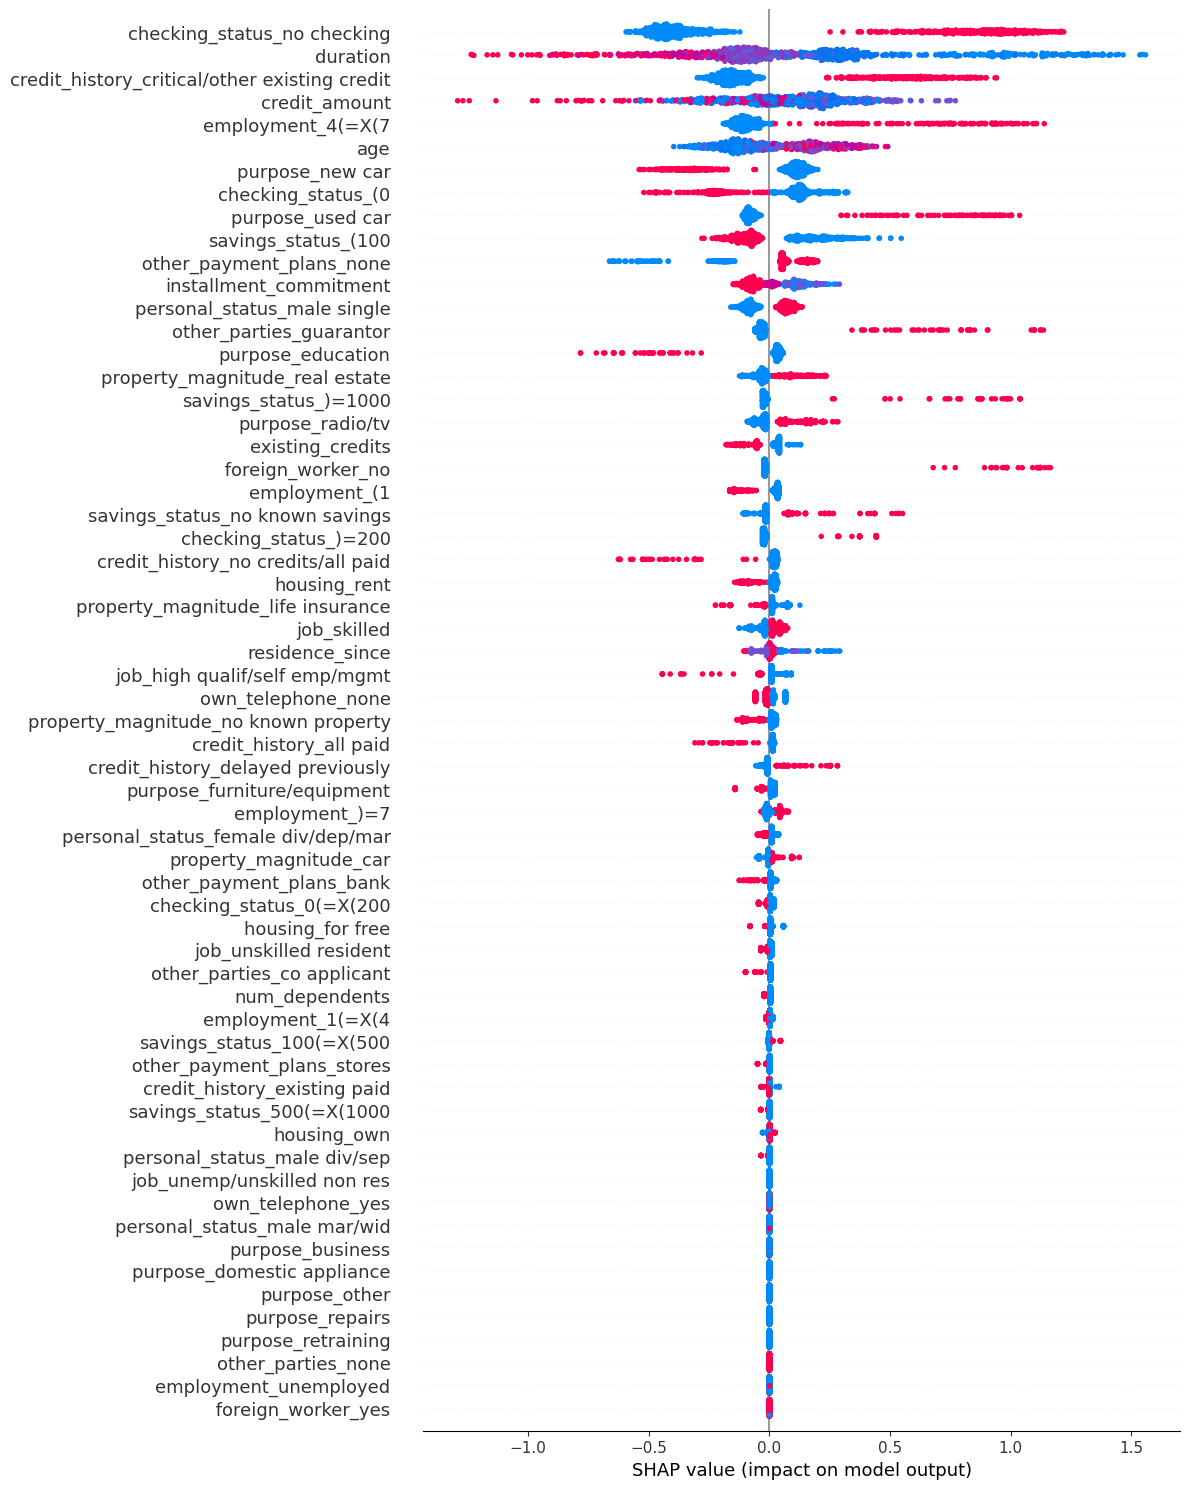

In [202]:
print('Feature Importances using Shapley Values')
explainer = shap.Explainer(clf)
shap_values = explainer(X_train)
X_test_array = np.array(X_train)
shap.summary_plot(shap_values, X_test_array, feature_names=X.columns, plot_size=(12,15), color_bar=False, max_display=X.shape[1])
plt.show()

#### Finding a good cutoff to keep only important features

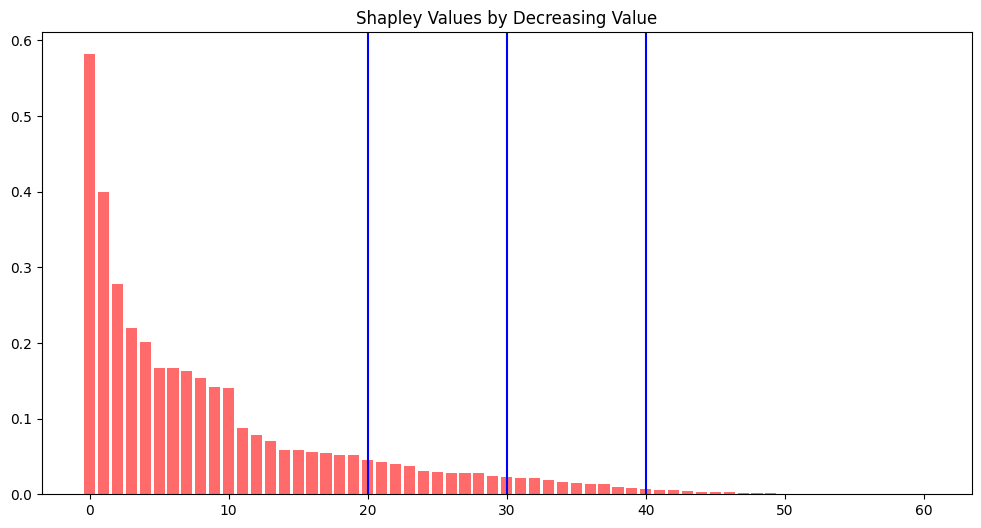

In [203]:
vals = np.abs(shap_values.values).mean(0)
feature_names = X.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
feature_importance.reset_index(drop=True, inplace=True)

fig,ax = plt.subplots(figsize=(12,6))
plt.bar(feature_importance.index, feature_importance['feature_importance_vals'], color='#FF6B6B')
plt.axvline(20,color='blue')
plt.axvline(30,color='blue')
plt.axvline(40,color='blue')
plt.title('Shapley Values by Decreasing Value')
plt.show()

### Feature Selection:
- Using both methodologies it looks like we can drop the last ~40 features
- With more time, I would want to test combinations of features to find the best one
- In this case we'll try with the top 20 features

In [204]:
selected_features = list(feature_importance['col_name'][:20])
X_train, X_test = X_train[selected_features], X_test[selected_features]

### Validation - Tuning
- We'll try combinations of parameters and look for high recall (0 class) and good F1 Score (1 class)
- The assumption is that measuring credit risk means we are trying to identity as many risky customers as possible
- We'll run a grid search using KFold validation to find the best combination of parameters
- The criterion will be negative recall


In [205]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=41)

def run_mod(params):
    lr, ne, sp, md = params
    clf_k = xgb.XGBClassifier(
    learning_rate = lr, 
    n_estimators = ne,
    scale_pos_weight=sp,
    max_depth = md,
    use_label_encoder=False,
    verbosity = 0
    )
    
    #Use kfold validation
    kfold = KFold(4, shuffle = True, random_state = 12)
    feat_cols = X_train.columns
    df_kfold = X_train.copy()
    df_kfold['class'] = y_train
    
    #create lists to collect recalls and f1s for each Kfold
    recall_list = []
    f1_list = []
    neg_recall_list = []
    neg_f1_list = []
    
    #train the model and test it on the validation set for each fold
    for train, val in kfold.split(X_train, y_train):
        df_train_, df_val = df_kfold.iloc[train], df_kfold.iloc[val]
        X_train_, X_val = df_train_.loc[:,feat_cols], df_val.loc[:,feat_cols]
        y_train_, y_val = df_train_['class'], df_val['class']
        clf_k.fit(X_train_,y_train_)
        val_pred = clf_k.predict(X_val)
        recall_list.append(recall_score(y_val, val_pred))
        f1_list.append(f1_score(y_val, val_pred))
        neg_recall_list.append(recall_score(y_val, val_pred, pos_label=0))
        neg_f1_list.append(f1_score(y_val, val_pred, pos_label=0))
    
    #calculate the average value across folds for recall and f1 
    recall, f1 , neg_recall, neg_f1 = np.mean(recall_list), np.mean(f1_list), np.mean(neg_recall_list), np.mean(neg_f1_list)
    return recall, f1, neg_recall, neg_f1

#Create a grid with all combinations of parameters
learning_rate_list = [0.01,0.1,0.2]
n_estimator_list = [50,100,200]
scale_pos_weight_list = [0.45,0.7,1]
max_depth_list = [5,8,10]

grid = [[a,b,c,d] for a in learning_rate_list for b in n_estimator_list for c in scale_pos_weight_list for d in max_depth_list]  

#Store results in a dataframe and sort by negative recall to get the best performers
val_df = pd.DataFrame(columns = ['params', 'neg_recall', 'neg_f1_score', 'recall', 'f1_score'])

for i,tup in enumerate(grid):
    recall, f1, neg_recall, neg_f1 = run_mod(tup)
    val_df.loc[i] = [tup, neg_recall, neg_f1,recall, f1]

val_df.sort_values('neg_recall', ascending=False, inplace = True)
val_df = val_df.loc[val_df['f1_score'] >= 0.5]
print(val_df.head(10))


                   params  neg_recall  neg_f1_score    recall  f1_score
0     [0.01, 50, 0.45, 5]    0.707679      0.561379  0.669883  0.747444
9    [0.01, 100, 0.45, 5]    0.672344      0.553401  0.694726  0.759301
18   [0.01, 200, 0.45, 5]    0.623343      0.545421  0.731512  0.775950
1     [0.01, 50, 0.45, 8]    0.616803      0.535012  0.722989  0.767958
2    [0.01, 50, 0.45, 10]    0.595806      0.525141  0.730146  0.768731
10   [0.01, 100, 0.45, 8]    0.590587      0.527355  0.738641  0.774363
11  [0.01, 100, 0.45, 10]    0.582112      0.535541  0.763271  0.788651
19   [0.01, 200, 0.45, 8]    0.582017      0.543631  0.775425  0.796638
27     [0.1, 50, 0.45, 5]    0.567429      0.537970  0.780524  0.797799
20  [0.01, 200, 0.45, 10]    0.555611      0.527477  0.779083  0.794450


### Run Model with the best Performance:
- Recall on bad credits gets up to 70% on the test set

In [206]:
params = val_df['params'][0]
print(params)

lr, ne, sp, md = params

clf_final = xgb.XGBClassifier(
learning_rate = lr, 
n_estimators = ne,
scale_pos_weight=sp,
max_depth = md,
use_label_encoder=False,
verbosity = 0
)

clf_final.fit(X_train, y_train)
y_pred = clf_final.predict(X_test)

print(classification_report(y_test, y_pred))

[0.01, 50, 0.45, 5]
              precision    recall  f1-score   support

           0       0.54      0.70      0.61        69
           1       0.81      0.69      0.74       131

    accuracy                           0.69       200
   macro avg       0.68      0.69      0.68       200
weighted avg       0.72      0.69      0.70       200



#### Business Application / Optimizing using Probability Score
- The default threshold value of 50% gives a recall of 0.70 and a precision of 54% on bad credits
- If we want to increase the precision to make sure that most people we flag actually have bad credit we can lower the threshold to 0.4. Precision then increases to 71%: we'll flag fewer customers with bad credit but we'll flag them with greater accuracy

In [207]:
y_prob = clf_final.predict_proba(X_test)
thresh = 0.4
y_proba_pred = [0 if x <= thresh else 1 for x in y_prob[:,1]]
print(classification_report(y_test, y_proba_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_proba_pred).ravel()
print('tn: ',tn)
print('fp: ',fp)
print('fn: ',fn)
print('tp: ',tp)

              precision    recall  f1-score   support

           0       0.71      0.22      0.33        69
           1       0.70      0.95      0.81       131

    accuracy                           0.70       200
   macro avg       0.71      0.59      0.57       200
weighted avg       0.70      0.70      0.64       200

tn:  15
fp:  54
fn:  6
tp:  125
